<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Video_Classification_using_CNN_LSTMv1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, we will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

### Install and re-start the runtime

In [ ]:
!pip3 install imageio==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=0d57d1e8c0d51a801ceaedbc17f61274598309f4eadf4c88165b19922f4c26e1
  Stored in directory: /root/.cache/pip/wheels/96/5d/ce/bdbdb04744dac03906336eb0d01ff1e222061d3419c55c55f9
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [ ]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import os, glob
import cv2
import imageio
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10
MAX_SEQ_LENGTH = 20

NUM_TRAIN_SAMPLES = 120
NUM_TEST_SAMPLES = 60

NUM_FEATURES = 2048
print("Keras version:", keras.__version__)

Keras version: 2.15.0


### Load the data and generate frames of video

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [ ]:
data_dir = "Actions/train/"
test_data_dir = "Actions/test/"

def traverse_folder(folder_path):

    # List all items in the folder (files and subdirectories)
    items = os.listdir(folder_path)

    for item in items:
        item_path = os.path.join(folder_path, item)

        # Check if the item is a file or a subdirectory
        if os.path.isfile(item_path):
            head, tail = os.path.split(folder_path)
            last_folder = os.path.basename(head) if tail == '' else os.path.basename(folder_path)
            file_list.append(item_path)
            tags.append(last_folder)
        elif os.path.isdir(item_path):
            # Recursively traverse subdirectories
            traverse_folder(item_path)



In [ ]:
# Initiatize buckets
file_list=[]
tags=[]

# Traversing training data folder
folder_to_traverse = data_dir

# Call the function to traverse the folder
traverse_folder(folder_to_traverse)

data = {'video_name': file_list, 'tag': tags}
train_df = pd.DataFrame(data)
train_df.to_csv('train.csv', index=False)

print(len(file_list), len(tags))
train_df.head()

479 479


,video_name,tag
0,Actions/train/Walking/person09_walking_d2_unco...,Walking
1,Actions/train/Walking/person24_walking_d4_unco...,Walking
2,Actions/train/Walking/person11_walking_d2_unco...,Walking
3,Actions/train/Walking/person03_walking_d2_unco...,Walking
4,Actions/train/Walking/person19_walking_d1_unco...,Walking


In [ ]:
# Initiatize buckets
file_list=[]
tags=[]

# Traversing training data folder
folder_to_traverse = test_data_dir

# Call the function to traverse the folder
traverse_folder(folder_to_traverse)

data = {'video_name': file_list, 'tag': tags}
test_df = pd.DataFrame(data)

test_df.to_csv('test.csv', index=False)
print(len(file_list), len(tags))
test_df.head()

120 120


,video_name,tag
0,Actions/test/Walking/person15_walking_d4_uncom...,Walking
1,Actions/test/Walking/person12_walking_d4_uncom...,Walking
2,Actions/test/Walking/person18_walking_d3_uncom...,Walking
3,Actions/test/Walking/person21_walking_d3_uncom...,Walking
4,Actions/test/Walking/person10_walking_d1_uncom...,Walking


In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['Handclapping', 'Walking', 'boxing', 'handwaving', 'jogging', 'running']


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                print(f"Frame len: {len(frames)}")
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
path = train_df["video_name"].values.tolist()[0]
print(path)
frames = load_video(path)
frames.shape

Actions/train/Walking/person09_walking_d2_uncomp.avi


(805, 224, 224, 3)

In [ ]:
path = test_df["video_name"].values.tolist()[0]
print(path)
min1=0
for i in range(479):
  frames = load_video(path)
  frames.shape
  min(min1)

Actions/test/Walking/person15_walking_d4_uncomp.avi


(678, 224, 224, 3)

In [ ]:
# Build another training set with raw frames - 10 frames per video

def prepare_all_videos_4_transfer_learning(df,num_samples):
    num_samples_per_class = int(num_samples/6)

    print(f"The shape of dataframe received: {df.shape}")
    print(f"Number of samples: {num_samples_per_class}")

    # Create an empty DataFrame to store the sampled rows
    sampled_df = pd.DataFrame()
    # Specify the number of rows to pick for each tag
    rows_per_tag = num_samples_per_class
    # Group by the 'tag' column
    grouped = df.groupby('tag')

    # Iterate over each group, pick num of samples needed and add to a dataframe
    for tag, group in grouped:
        sampled_rows = group.sample(min(rows_per_tag, len(group)))
        temp_df = pd.DataFrame(sampled_rows)
        sampled_df = pd.concat([sampled_df, temp_df], ignore_index=True)

    # Reset the index of the sampled DataFrame
    sampled_df.reset_index(drop=True, inplace=True)

    print(f"Sampled df shape: {sampled_df.shape}")
#     print(sampled_df.head())

    df=sampled_df

    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = np.array(label_processor(labels[..., None]))

    print(f"Video paths in df : {len(video_paths)}")
    print(f"label shape is {labels.shape}")

    image_frames_set = []

    # For each video Gather all its frames
    for idx, path in enumerate(video_paths):
        frames = load_video(path)[200:210]
        image_frames_set.append(frames)

    # Convert the list of image frames set into a tensor and labels as a 1D array
    images = image_frames_set
    # print(images.shape)
    images = [np.expand_dims(img, axis=0) for img in images]
    image_frames_set = np.vstack(images)
    labels = labels.reshape((num_samples_per_class*6,))

    print(f"Shape of image_frame_set : {image_frames_set.shape}")
    print(f"Shape of labels : {labels.shape}")

    return image_frames_set, labels

# train_df = pd.read_csv('/content/train.csv')
train_data_tf, train_label_tf = prepare_all_videos_4_transfer_learning(train_df, NUM_TRAIN_SAMPLES)
test_data_tf, test_label_tf = prepare_all_videos_4_transfer_learning(test_df, NUM_TEST_SAMPLES)

The shape of dataframe received: (479, 2)
Number of samples: 20
Sampled df shape: (120, 2)
Video paths in df : 120
label shape is (120, 1)
Shape of image_frame_set : (120, 10, 224, 224, 3)
Shape of labels : (120,)
The shape of dataframe received: (120, 2)
Number of samples: 10
Sampled df shape: (60, 2)
Video paths in df : 60
label shape is (60, 1)
Shape of image_frame_set : (60, 10, 224, 224, 3)
Shape of labels : (60,)


In [ ]:
# import tensorflow as tf
# from tensorflow import image
# import numpy as np

# # Load and preprocess the images
# # images = [image.load_img(img_path, target_size=(224, 224)) for img_path in image_paths]
# images = train_data_tf
# # print(images.shape)

# images = [np.expand_dims(img, axis=0) for img in images]
# train_data_tf = np.vstack(images)

# images = test_data_tf
# # print(images.shape)

# images = [np.expand_dims(img, axis=0) for img in images]
# test_data_tf = np.vstack(images)

# # Print the shape of the resulting tensor
# print("Tensor shape train data :", train_data_tf.shape)
# print("Tensor shape train data :", test_data_tf.shape)

# train_label_tf = train_label_tf.reshape((120,))
# test_label_tf = test_label_tf.reshape((60,))

# print(f"Train and test label shapes: {train_label_tf.shape}, {test_label_tf.shape}")


Tensor shape train data : (120, 10, 224, 224, 3)
Tensor shape train data : (60, 10, 224, 224, 3)
Train and test label shapes: (120,), (60,)


In [ ]:

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:

def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    print(len(labels),len(video_paths))

    # labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))
    labels = np.array(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

# prepare_all_videos(train_df)

train_data, train_labels = prepare_all_videos(train_df)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Frame feature labels in train set: {train_labels.shape}")

test_data, test_labels = prepare_all_videos(test_df)
print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")
print(f"Frame feature labels in test set: {test_labels.shape}")



479 479


[mpeg4 @ 0x5a9ec43d6800] ac-tex damaged at 8 6
[mpeg4 @ 0x5a9ec43d6800] Error at MB: 74


#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

In [ ]:

# Convert the list of features to a 2D NumPy array
# # features_array = train_data[0]
# features_array = np.array(train_data[0]).squeeze()

# # Use PCA for dimensionality reduction (adjust n_components as needed)
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(features_array)

# # Scatter plot of the reduced features
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
# plt.title('Scatter Plot of InceptionV3 Features')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

### Create the Neural Network

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10

11/11 [==============================] - ETA: 0s - loss: 1.6500 - accuracy: 0.2269

Epoch 1: val_loss improved from inf to 2.77284, saving model to /tmp/video_classifier/ckpt.weights.h5

11/11 [==============================] - 13s 336ms/step - loss: 1.6500 - accuracy: 0.2269 - val_loss: 2.7728 - val_accuracy: 0.0000e+00

Epoch 2/10

11/11 [==============================] - ETA: 0s - loss: 1.5895 - accuracy: 0.2746

Epoch 2: val_loss did not improve from 2.77284

11/11 [==============================] - 1s 57ms/step - loss: 1.5895 - accuracy: 0.2746 - val_loss: 3.0192 - val_accuracy: 0.0000e+00

Epoch 3/10

11/11 [==============================] - ETA: 0s - loss: 1.5099 - accuracy: 0.2925

Epoch 3: val_loss did not improve from 2.77284

11/11 [==============================] - 1s 80ms/step - loss: 1.5099 - accuracy: 0.2925 - val_loss: 3.0483 - val_accuracy: 0.0000e+00

Epoch 4/10

11/11 [==============================] - ETA: 0s - loss: 1.5074 - accuracy: 0.3373

Epoch 4: v

In [ ]:
train_data[0].shape, train_data[1].shape

((479, 20, 2048), (479, 20))

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

Test video path: /content/Actions/test/handwaving/person10_handwaving_d2_uncomp.avi

1/1 [==============================] - 0s 148ms/step

1/1 [==============================] - 0s 136ms/step

1/1 [==============================] - 0s 140ms/step

1/1 [==============================] - 0s 137ms/step

1/1 [==============================] - 0s 152ms/step

1/1 [==============================] - 0s 143ms/step

1/1 [==============================] - 0s 141ms/step

1/1 [==============================] - 0s 138ms/step

1/1 [==============================] - 0s 138ms/step

1/1 [==============================] - 0s 144ms/step

1/1 [==============================] - 0s 153ms/step

1/1 [==============================] - 0s 136ms/step

1/1 [==============================] - 0s 139ms/step

1/1 [==============================] - 0s 142ms/step

1/1 [==============================] - 0s 141ms/step

1/1 [==============================] - 0s 154ms/step

1/1 [==============================] - 0s 138ms/ste

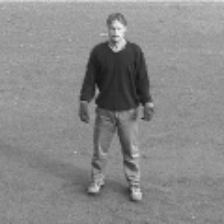

In [ ]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

### Use pre-trained model for feature extraction

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.optimizers import Nadam

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3))

# # do not train first layers, I want to only train
# # the 4 last layers (my own choice, up to you)
for layer in vgg.layers:
    layer.trainable = False # create a Sequential model

model = Sequential()# add vgg model for 10 input images (keeping the right shape
model.add(TimeDistributed(vgg, input_shape=(10, 224, 224, 3)))

# now, flatten on each output to send 5
# outputs with one dimension to LSTM
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, activation='relu', return_sequences=False))# finalize with standard Dense, Dropout...

model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(6, activation='softmax'))

# Model Summary
model.summary()
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 7, 7, 512)     14714688  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 25088)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 256)               25953280  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
train_data_tf.shape, train_label_tf.shape, test_data_tf.shape, test_label_tf.shape

((120, 10, 224, 224, 3), (120,), (60, 10, 224, 224, 3), (60,))

In [ ]:
# Utility for running experiments.
def run_experiment_VGG16():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = model
    history = seq_model.fit(
        train_data_tf,
        train_label_tf,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate(test_data_tf, test_label_tf)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment_VGG16()

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 61.6063 - accuracy: 0.3095
Epoch 1: val_loss improved from inf to 83.59457, saving model to /tmp/video_classifier/ckpt.weights.h5
3/3 [==============================] - 95s 22s/step - loss: 61.6063 - accuracy: 0.3095 - val_loss: 83.5946 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 182.7139 - accuracy: 0.2024
Epoch 2: val_loss did not improve from 83.59457
3/3 [==============================] - 5s 2s/step - loss: 182.7139 - accuracy: 0.2024 - val_loss: 93.8455 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 216.5076 - accuracy: 0.2857
Epoch 3: val_loss did not improve from 83.59457
3/3 [==============================] - 5s 2s/step - loss: 216.5076 - accuracy: 0.2857 - val_loss: 197.5043 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 263.4088 - accuracy: 0.2500
Epoch 4: val_loss did not

Test video path: Actions/test/boxing/person03_boxing_d2_uncomp.avi
1/1 [==============================] - 0s 37ms/step
  Handclapping:  0.00%
  Walking:  0.00%
  handwaving:  0.00%
  jogging:  0.00%
  running:  0.00%
  boxing: 100.00%


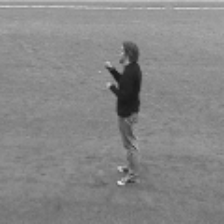

In [ ]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

def sequence_prediction_tf(path):
    class_vocab = label_processor.get_vocabulary()
    frames = load_video(path)[:10]
    frames_set = frames[np.newaxis,...]
    probabilities = sequence_model.predict(frames_set)

    for i in np.argsort(probabilities)[0]:
        print(f"  {class_vocab[i]}: {probabilities[0][i] * 100:5.2f}%")

    return frames


# # This utility is for visualization.
# # Referenced from:
# # https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction_tf(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

Actions/test/Walking/person18_walking_d3_uncomp.avi
Total frames recived and shape of frames: = (100, (100, 224, 224, 3)) 


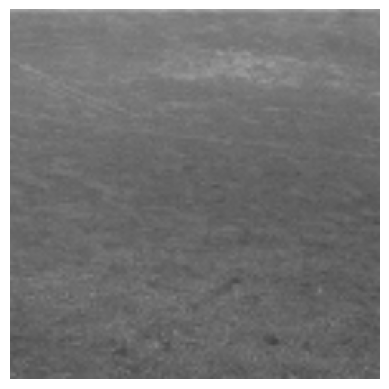

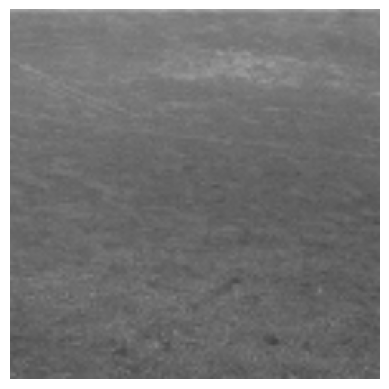

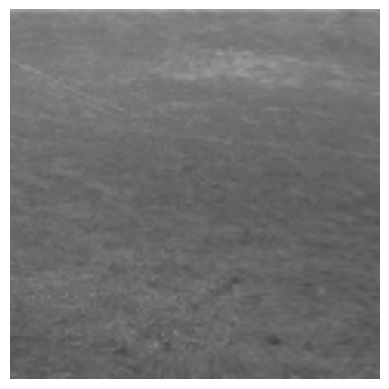

Frame len: 3


In [ ]:
# Some utility functions

import cv2
import numpy as np
# import cv2_imshow

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
def disp_frames(path, max_frames=10):

    cap = cv2.VideoCapture(path)
    frames = []
    # Check if camera opened successfully
    if (cap.isOpened() == False):
        print("Error opening video stream or file")

    # Read until video is completed
    while (cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:

            # Convert BGR image to RGB (matplotlib uses RGB)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame using matplotlib
            plt.imshow(frame_rgb)
            plt.axis('off')  # Hide axes
            plt.show()
            frames.append(frame)

            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            if len(frames) == max_frames:
                print(f"Frame len: {len(frames)}")
                break

        # Break the loop
        else:
            break

    # When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()

def disp_frames_new(frames, max_frames=10):
    print(f"Total frames recived and shape of frames: = {len(frames), frames.shape} ")
    for i in range(len(frames)):
        # Convert BGR image to RGB (matplotlib uses RGB)
            frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)

            # Display the frame using matplotlib
            plt.imshow(frame_rgb)
            plt.axis('off')  # Hide axes
            plt.show()

            if i+1 == max_frames:
                print(f"Frame len: {i+1}")
                break


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


print(file_list[2])
# disp_frames(file_list[2])
sample_video = load_video(file_list[2])[:100]
disp_frames_new(sample_video,3)
# print(sample_video.shape)
# to_gif(file_list[2])

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification